<a href="https://colab.research.google.com/github/leinaxd/NOTES/blob/main/digital_image_processing/notebooks/12a_thresholding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thresholding
```
Author: Eichenbaum Daniel
Email: eichenbaum.daniel@gmail.com
```

This is a practical demo to understand the theory behind:
  ```
DIP Lecture 12: Thresholding ¬Rich Radke
  https://www.youtube.com/watch?v=ojapO75FV38&list=PLuh62Q4Sv7BUf60vkjePfcOQc8sHxmnDX&index=12
  
Textbook: 10.3-10.4 Digital Image Processing
  Gonzalez and Woods, 3rd ed.  
  https://www.amazon.com/-/es/Rafael-Gonzalez/dp/0133356728  
  ```

(1200, 1600, 3)


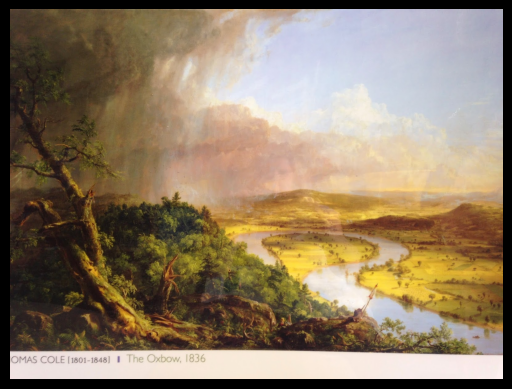

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
plt.style.use('dark_background')


url = "https://github.com/leinaxd/NOTES/raw/main/digital_image_processing/notebooks/background.jpg"
with urllib.request.urlopen(url) as url:
    img = plt.imread(url, format='jpg')
plt.imshow(img)
plt.axis('off')

print(img.shape)

r_mask = img[:, :, 0]
g_mask = img[:, :, 1]
b_mask = img[:, :, 2]

#turn image to gray
g_img = r_mask*0.2989 + g_mask*0.5870 + b_mask*0.1140
u_img = np.uint8(g_img)

# Image segmentation:

## Thresholding

Background separation

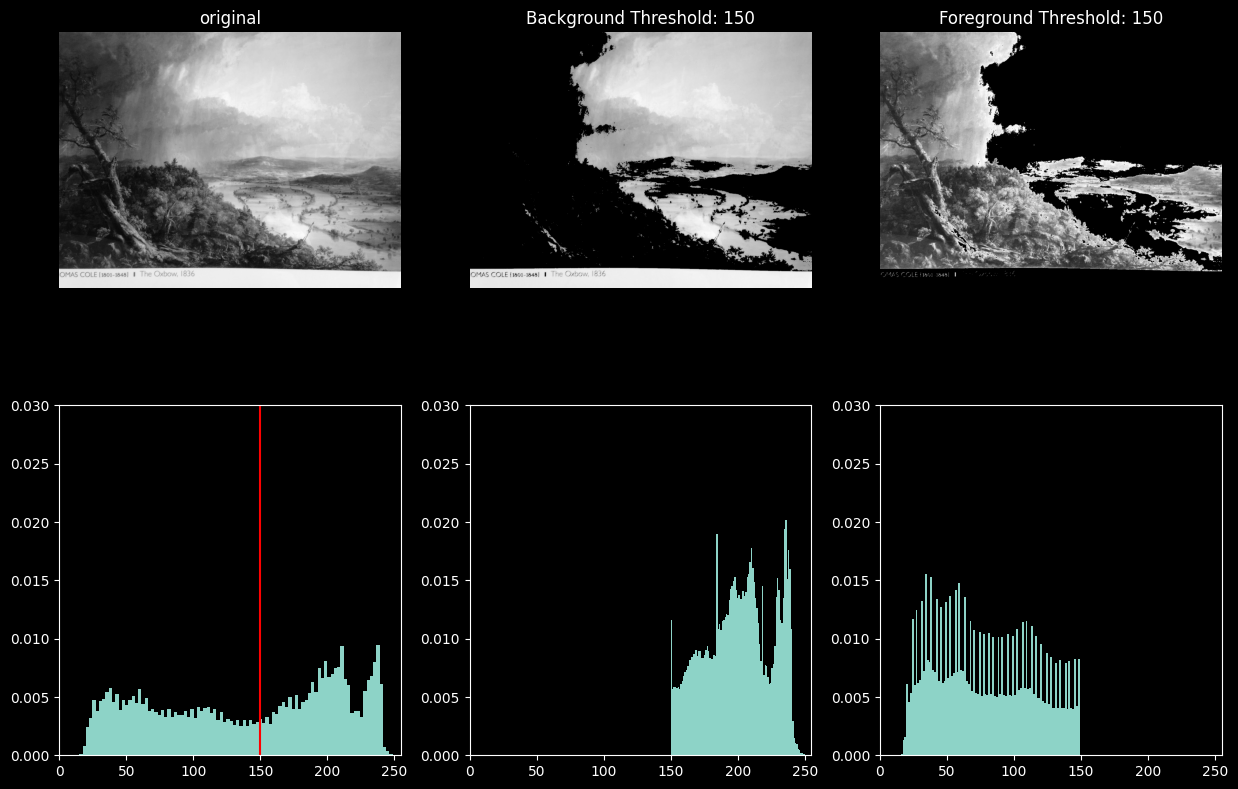

In [ ]:
nbins = 100 #@param{'type':'integer'}
th = 150 #@param {'type':'integer'}
ylim = 0.03 #@param {'type':'number'}
fig, ax = plt.subplots(2,3, figsize=(15,10))

ax[0][0].imshow(g_img, cmap='gray')
ax[0][0].axis('off')
ax[0][0].set_title('original');
ax[1][0].hist(g_img.flatten(), bins=nbins, density=True);
ax[1][0].axvline(th, color='r')
ax[1][0].set_xlim([0, 255]);
ax[1][0].set_ylim([0, ylim]);

im = (g_img > th)*g_img
im = np.uint8(im)
f_im = im.flatten()

ax[0][1].imshow(im, cmap='gray')
ax[0][1].set_title(f'Background Threshold: {th}');
ax[0][1].axis('off');
ax[1][1].hist(f_im[f_im.nonzero()], bins=nbins, density=True);
ax[1][1].set_xlim([0, 255]);
ax[1][1].set_ylim([0, ylim]);

im = (g_img <= th)*g_img
im = np.uint8(im)
f_im = im.flatten()

ax[0][2].imshow(im, cmap='gray')
ax[0][2].set_title(f'Foreground Threshold: {th}');
ax[0][2].axis('off');
ax[1][2].hist(f_im[f_im.nonzero()], bins=nbins, density=True)
ax[1][2].set_xlim([0, 255]);
ax[1][2].set_ylim([0, ylim]);

Synthetic image

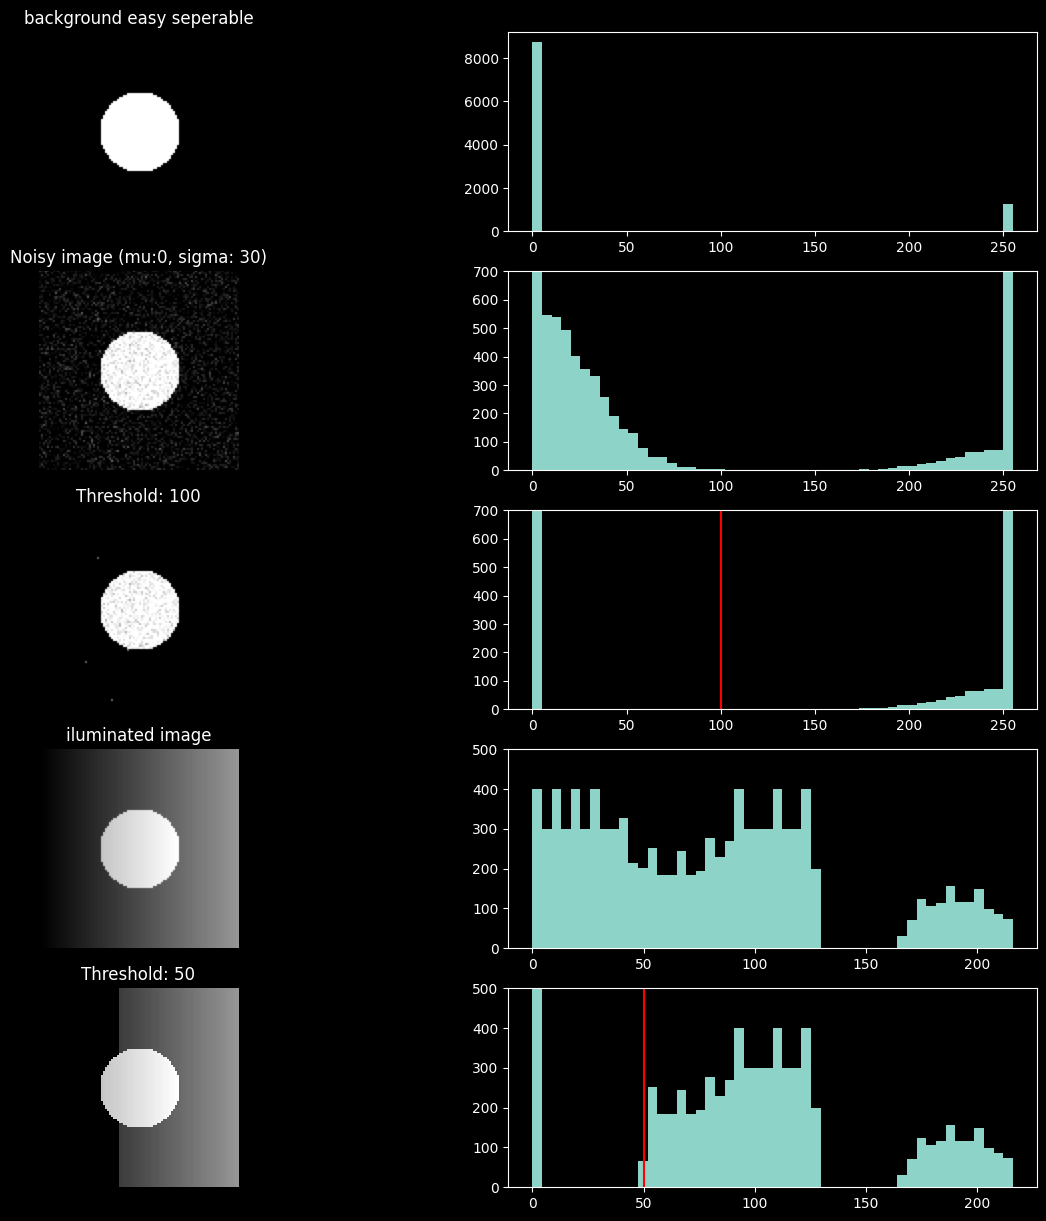

In [ ]:
nbins = 50 #@param {'type':'integer'}
x, y = np.meshgrid(np.arange(-50,50), np.arange(-50,50))

im  = (x*x + y*y < 400)*255
im = np.uint8(im)

fig, ax = plt.subplots(5,2, figsize=(15,15))

ax[0][0].imshow(im, cmap='gray')
ax[0][0].set_title('background easy seperable');
ax[0][0].axis('off');
ax[0][1].hist(im.flatten(), bins=nbins);

mu, sigma = 0,30
noise = np.random.normal(mu, sigma, im.shape)

im  = im+noise
im  = np.clip(im, 0, 255)
im = np.uint8(im)

ax[1][0].imshow(im, cmap='gray')
ax[1][0].set_title(f'Noisy image (mu:{0}, sigma: {30})');
ax[1][0].axis('off');
ax[1][1].hist(im.flatten(), bins=nbins);
ax[1][1].set_ylim([0, 700]);

th = 100
im = (im>th)*im
im = np.uint8(im)

ax[2][0].imshow(im, cmap='gray')
ax[2][0].set_title(f'Threshold: {th}');
ax[2][0].axis('off');
ax[2][1].hist(im.flatten(), bins=nbins);
ax[2][1].axvline(th, color='r')
ax[2][1].set_ylim([0, 700]);


im  = (x*x + y*y < 400)*255
g = np.ones((100,1))*np.linspace(0,255,100);
im  = 0.5*im+0.5*g
im = np.uint8(im)

ax[3][0].imshow(im, cmap='gray')
ax[3][0].set_title(f'iluminated image');
ax[3][0].axis('off');
ax[3][1].hist(im.flatten(), bins=nbins);
ax[3][1].set_ylim([0, 500]);

th = 50
im = (im > th)*im
im = np.uint8(im)

ax[4][0].imshow(im, cmap='gray')
ax[4][0].set_title(f'Threshold: {th}');
ax[4][0].axis('off');
ax[4][1].hist(im.flatten(), bins=nbins);
ax[4][1].axvline(th, color='r')
ax[4][1].set_ylim([0, 500]);


---
**Basic global thresholding**

 Automatically select a Threshold T through iteration

1. Select initial estimate of **T** (maybe the avg of pixel intensity)
2. Segment image into 2 groups, **G1 > T** and **G2<=T**
3. Compute de avg mean of G1 and G2, named **mu_1** and **mu_2**
4. Compute the threshold midway between mu_1 and mu_2.
   **T=0.5*(mu_1+mu_2)**
5. Repeat 2-4 until convergence.

This basic algorithm performs well in situations where there is a clear valley between the modes of the histogram related to objects and background

---

mu_1:100, mu_2:39, th:150.0
mu_1:129, mu_2:10, th:69.5
mu_1:129, mu_2:10, th:69.5


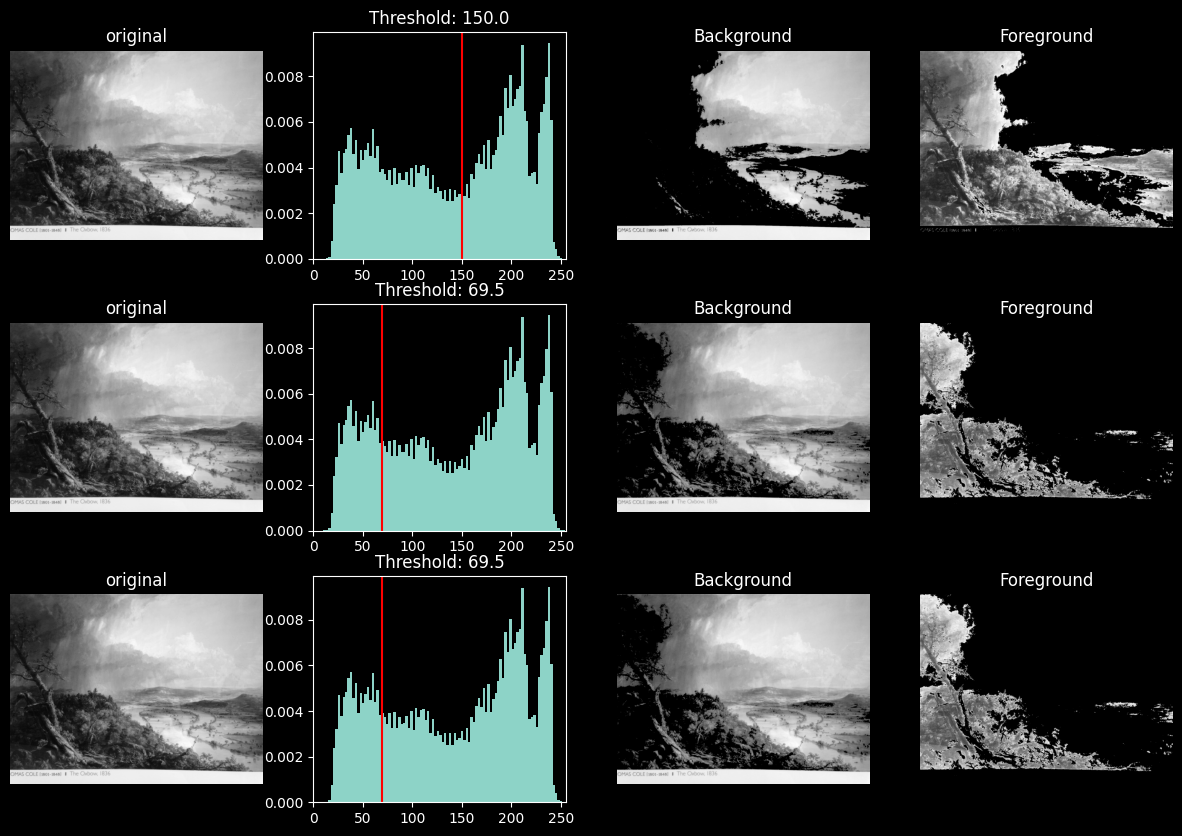

In [ ]:
initialTh = 150 #@param {'type':'integer'}
nIters = 3 #@param {'type':'integer'}
nbins = 100 #@param{'type':'integer'}
fig, ax = plt.subplots(nIters,4, figsize=(15,10))

#Algorithm
mu_1 = mu_2 = initialTh
for i in range(nIters):
    th = 0.5*(mu_1 + mu_2)
    im_1 = (g_img > th)*g_img
    im_2 = (g_img <=th)*g_img
    im_1 = np.uint8(im_1)
    im_2 = np.uint8(im_2)

    mu_1 = im_1.mean(dtype=int)
    mu_2 = im_2.mean(dtype=int)

    print(f"mu_1:{mu_1}, mu_2:{mu_2}, th:{th}")

    f_im_1 = im_1.flatten()
    f_im_2 = im_2.flatten()

    ax[i][0].imshow(g_img, cmap='gray')
    ax[i][0].axis('off')
    ax[i][0].set_title('original');
    ax[i][1].hist(g_img.flatten(), bins=nbins, density=True);
    ax[i][1].axvline(th, color='r')
    ax[i][1].set_xlim([0, 255]);
    ax[i][1].set_title(f'Threshold: {th}');

    ax[i][2].imshow(im_1, cmap='gray')
    ax[i][2].set_title(f'Background');
    ax[i][2].axis('off');

    ax[i][3].imshow(im_2, cmap='gray')
    ax[i][3].set_title(f'Foreground');
    ax[i][3].axis('off');

---

**OTSU's Algorithm**

- Used to find the best global Threshold T between classes.

- Where the Image is composed of light objects on a dark background

- An alternative to the Bayesian approach (used with gaussian distributions, minimizing the avg sq error incurred in assigning pixels to two or more groups)

![](https://github.com/leinaxd/NOTES/raw/main/digital_image_processing/Lecture_12/class_histograms.jpeg)

---

Idea.
- Split the pixels into 2 classes (Background or Foreground) as well separatad as possible.
- Maximize the between-class variance.
(properly thresholded classes should be distinct with respect to the intensity values of their pixelse and conversely, that a threshold giving the best separation between classes would be the best threshold)
- A good threshold should separate pixels into tight clusters

Let $L=\{0, 1, .. L-1\}$ denote the set of L distinct integer intensity levels in a digital image of size M x N

Let $n_i$ denote the number of pixels with intensity i. The total number, NM of pixels in the image is $MN = n_0+n_1 + ... + n_{L-1}$

The normalized histogram has components $p_i = \frac{n_i}{MN}$ where $\sum p_i = 1$

![](https://github.com/leinaxd/NOTES/raw/main/digital_image_processing/Lecture_12/global_statistics.jpeg)

Given a threshold $T$, define two classes.

$C_1 = \{ (x,y) | I(x,y) <= T\}$

$C_2 = \{ (x,y) | I(x,y) > T\}$

1. Compute the normalized histogram of the input image. Denote its components by $p_i=\{0,1,...,L-1\}$

2. Compute the cummulative sums, $P_1(T) = \sum_{i=0}^{T} p_i$ = P(I(x,y) <= T) for $0<T<L-1$

3. Compute the cummulative mean, $m(T)=\sum_{i=0}^T i p_i$

4. Compute the global mean of the entire image, $m_G(T) = \sum_{i=0}^{L-1} i p_i$

$ = m(T=L-1)$

5. Compute the between-class variance term,

$\sigma_B^2(T) = P_1 (m_1-m_G)^2+P_2 (m_2-m_G)^2 = P_1 P_2 (m_1 - m_2)^2=\frac{m_G P_1 - m}{P_1 (1-P_1)}$

**Note 1:**

- $P_1 m_1 + P_2 m_2 = m_G$
- $P_1 + P_2 = 1$

- $m_1(T) = \sum_{i=0}^T i P(i | i\in c_1)$
 $=\sum_{i=0}^T i\frac{\overbrace{P(i\in c_1 | i)}^{=1} P(i)}{P(c_1)}=\frac{1} {P_1(T)}\sum_{i=0}^T i p_i$

- $m_2(T)=\frac{1}{P_2(T)}\sum_{i=T+1}^{L-1} i p_i$

**Note 2:**

 The farther the means $m_1$ and $m_2$ are, the greater the $\sigma_B^2$ variance will be. Implying that the between class variance is a measure of separability between classes.

 6. Obtain the Otsu's threshold $T^*$. If the maximum is not unique, obtain $T^*$ by averaging values of $T$ corresponding to the various maxima detected.

 $T^* = \underset{T\in [0, L-1]}{argmax}\ \sigma^2_B(T)$

So Otsu's criterion is to maximize the between-class variance

![](https://github.com/leinaxd/NOTES/raw/main/digital_image_processing/Lecture_12/global_statistics_5.jpeg)

 7. Compute the global variance $\sigma^2_G = \sum_{i=0}^{L-1}(i-m_G)^2 p_i$

 8. Compute the separability measure $\eta=\sigma^2_B/\sigma^2_G$

 The measure $\sigma_b^2/\sigma_a^2$ is a good measure of separability


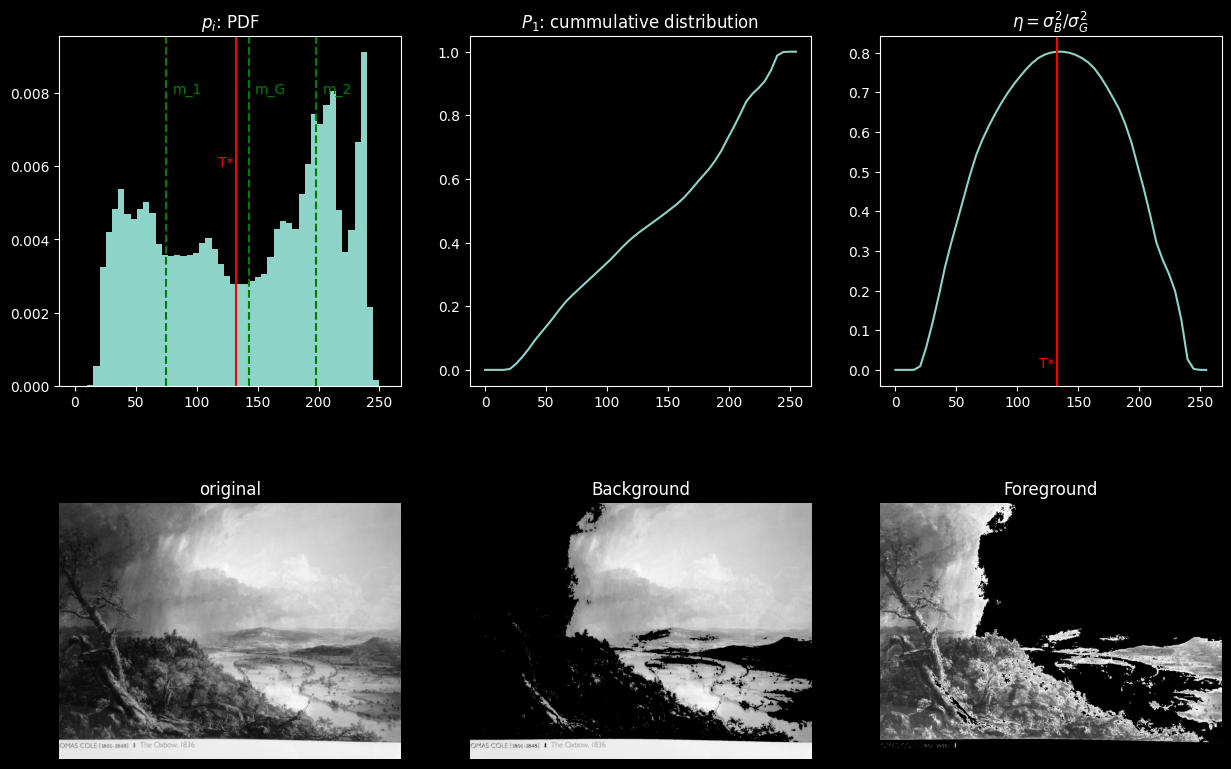

In [ ]:
nbins = 50 #@param {'type':'integer'}

#Algorithm
# step 1
h_im, p_im = np.histogram(g_img.flatten(), bins=nbins,density=True, range=[0,255])
w_bar = p_im[1:]-p_im[:-1] #width of each histogram bar
intensities = np.zeros_like(p_im) #x axis
intensities[1:] = np.cumsum(w_bar)
p_i = np.zeros_like(p_im) #adds zero prob to intensity < 0
p_i[1:] = h_im * w_bar #prob = area of each histogram bar

# print(len(h_im))
# step 2
P_1 = np.cumsum(p_i)
# plt.hist(g_img.flatten(), density=True, bins=nbins, alpha=0.2)

#step 3
m = np.cumsum(intensities*p_i)

#step 4
m_G = m[-1]

#step 5
sigma_B = (m_G * P_1-m)**2/(1E-10+P_1*(1-P_1))

#step 6
ix_star = np.argmax(sigma_B)
T_star  = intensities[ix_star]

#step 7
sigma_G = np.sum((intensities-m_G)**2 * p_i)

#step 8
eta = sigma_B[ix_star]/sigma_G

#Others
m_1 = m[ix_star]/P_1[ix_star]
m_2 = (m_G - m[ix_star])/(1-P_1[ix_star])

im_1 = (g_img > T_star)*g_img
im_2 = (g_img <=T_star)*g_img
im_1 = np.uint8(im_1)
im_2 = np.uint8(im_2)

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax[0][0].bar(p_im[:-1], h_im, align='edge', width=1*w_bar[0])
ax[0][0].set_title('$p_i$: PDF')
ax[0][0].text(T_star-15, 0.006, 'T*',color='r')
ax[0][0].axvline(T_star, color='r')
ax[0][0].text(m_G+5, 0.008, 'm_G',color='g')
ax[0][0].axvline(m_G, color='g', linestyle='--')
ax[0][0].text(m_1+5, 0.008, 'm_1',color='g')
ax[0][0].axvline(m_1, color='g', linestyle='--')
ax[0][0].text(m_2+5, 0.008, 'm_2', color='g')
ax[0][0].axvline(m_2, color='g', linestyle='--')


ax[0][1].plot(intensities, P_1)
ax[0][1].set_title('$P_1$: cummulative distribution')

ax[0][2].plot(intensities, sigma_B/sigma_G)
ax[0][2].set_title('$\eta = \sigma^2_B/\sigma^2_G$')
ax[0][2].text(T_star-15, 0.006, 'T*',color='r')
ax[0][2].axvline(T_star, color='r')

ax[1][0].imshow(g_img, cmap='gray')
ax[1][0].axis('off')
ax[1][0].set_title('original');

ax[1][1].imshow(im_1, cmap='gray')
ax[1][1].set_title(f'Background');
ax[1][1].axis('off');

ax[1][2].imshow(im_2, cmap='gray')
ax[1][2].set_title(f'Foreground');
ax[1][2].axis('off');

## Block Processing

In [19]:
class blockProc:
    """
    Let be an image of size NxM,
    Applies a function <func> to each (sx,sy) block of the image <img>
    returns the concatenated version of that blocked transfomed image.
    """

    def __init__(self, block_size):
        self.block_size = block_size

    def __call__(self, img:np.ndarray, func):
        assert callable(func), 'func must be a callable'
        R = img.shape[0]//self.block_size[0] #num of row blocks
        C = img.shape[1]//self.block_size[1] #num of col blocks
        new_img = np.zeros_like(img)
        re = 0
        for r in range(R):
            rs = re
            re   = rs + self.block_size[0]
            ce = 0
            for c in range(C):
                cs = ce
                ce = cs + self.block_size[1]
                new_img[rs:re, cs:ce] = func(img[rs:re,cs:ce])

        return new_img



In [20]:
def OTSU(img, nbins=100):
    #Algorithm
    # step 1
    h_im, p_im = np.histogram(img.flatten(), bins=nbins,density=True, range=[0,255])
    w_bar = p_im[1:]-p_im[:-1] #width of each histogram bar
    intensities = np.zeros_like(p_im) #x axis
    intensities[1:] = np.cumsum(w_bar)
    p_i = np.zeros_like(p_im) #adds zero prob to intensity < 0
    p_i[1:] = h_im * w_bar #prob = area of each histogram bar

    # step 2
    P_1 = np.cumsum(p_i)

    #step 3
    m = np.cumsum(intensities*p_i)

    #step 4
    m_G = m[-1]

    #step 5
    sigma_B = (m_G * P_1-m)**2/(1E-10+P_1*(1-P_1))

    #step 6
    ix_star = np.argmax(sigma_B)
    T_star  = intensities[ix_star]
    return T_star

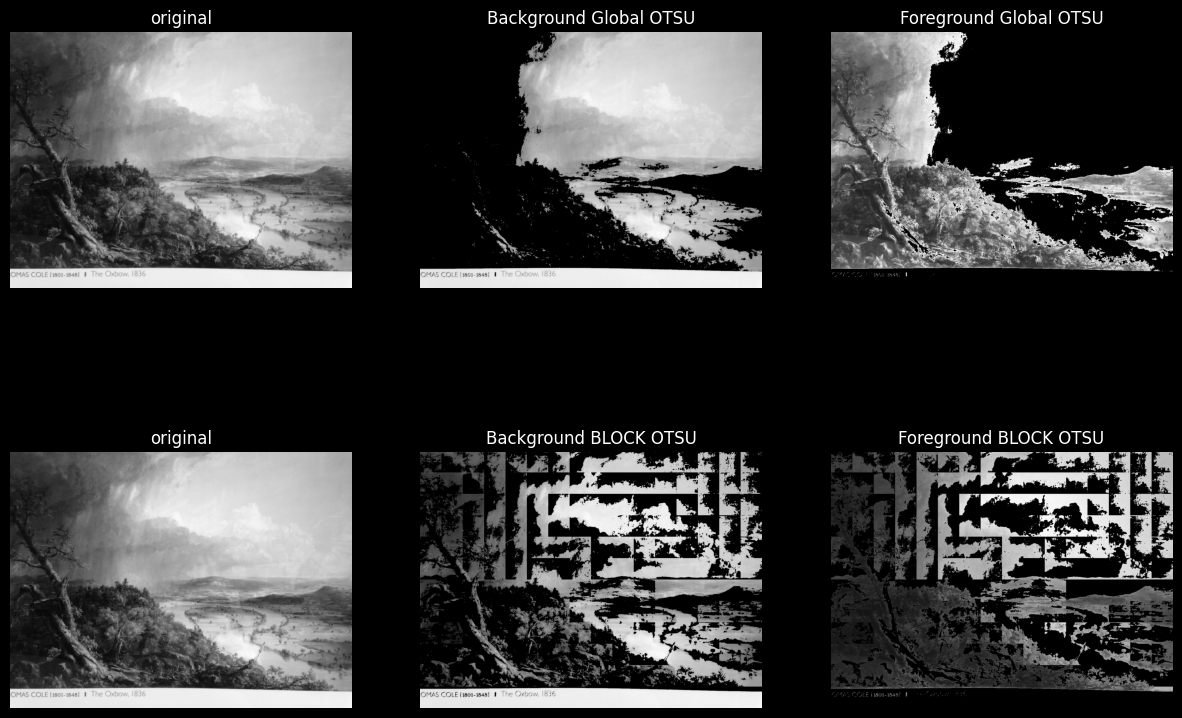

In [26]:
block_size =(100,100) #@param {}
T_star = OTSU(g_img)

im_1 = (g_img > T_star)*g_img
im_2 = (g_img <=T_star)*g_img
im_1 = np.uint8(im_1)
im_2 = np.uint8(im_2)

fig, ax = plt.subplots(2,3, figsize=(15,10))

ax[0][0].imshow(g_img, cmap='gray')
ax[0][0].axis('off')
ax[0][0].set_title('original');

ax[0][1].imshow(im_1, cmap='gray')
ax[0][1].set_title(f'Background Global OTSU');
ax[0][1].axis('off');

ax[0][2].imshow(im_2, cmap='gray')
ax[0][2].set_title(f'Foreground Global OTSU');
ax[0][2].axis('off');

def func_B(img):
    T_star = OTSU(img)
    im_1 = (img > T_star)*img
    im_1 = np.uint8(im_1)
    return im_1
def func_F(img):
    T_star = OTSU(img)
    im_2 = (img <=T_star)*img
    im_2 = np.uint8(im_2)
    return im_2
Proc = blockProc(block_size)
im_1 = Proc(g_img, func_B)
im_2 = Proc(g_img, func_F)

ax[1][0].imshow(g_img, cmap='gray')
ax[1][0].axis('off')
ax[1][0].set_title('original');

ax[1][1].imshow(im_1, cmap='gray')
ax[1][1].set_title(f'Background BLOCK OTSU');
ax[1][1].axis('off');

ax[1][2].imshow(im_2, cmap='gray')
ax[1][2].set_title(f'Foreground BLOCK OTSU');
ax[1][2].axis('off');